In [ ]:
#import shutil
#shutil.unpack_archive("/content/drive/MyDrive/RML2016.10b.tar.bz2","/content/drive/MyDrive/AI_assignment4/Data/")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
# imports cell
import numpy as np
import scipy as sp
import keras
import tensorflow as tf
import _pickle as cPickle
import matplotlib.pyplot as plt
import sys 
import gc

#-----------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from pandas import DataFrame as df

# Deep Learning libs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Conv2D,Reshape,Dropout,MaxPooling2D,BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelBinarizer as LB
from sklearn.preprocessing import normalize 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# reading file and separate data to X and Y

In [ ]:
filename = "/content/drive/MyDrive/AI_assignment4/Data/RML2016.10b.dat"
open_file = open(filename,'rb')
Xd = cPickle.load(open_file, encoding='latin1')

In [ ]:
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = [] 
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
open_file.close()
labels = np.array(lbl)
del(lbl)
gc.collect()

11

# Define different feature samples 

In [ ]:
features = {}
features['raw']        = X[:,0], X[:,1]
features['derivative'] = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))
features['integral']   = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))
del(X)
gc.collect()
def extract_features(*arguments):
  desired = ()            
  for arg in arguments:
      desired += features[arg]
  return np.stack(desired, axis = 1)

NameError: ignored

# split data into train and test using indeces

In [ ]:
def split_data(data):
  np.random.seed(10)
  n_examples = labels.shape[0]
  r = np.random.choice(range(n_examples), n_examples, replace = False)
  train_examples = r[:int(n_examples * (3/4))]
  test_examples =  r[int(n_examples * (3/4)):]
  X_train = data[train_examples]
  X_test = data[test_examples]
  y_train = LB().fit_transform(labels[train_examples][:,0])
  y_test = LB().fit_transform(labels[test_examples][:,0])
  snr_train = labels[train_examples][:,1].astype(int)
  snr_test = labels[test_examples][:,1].astype(int)

  del(train_examples)
  del(test_examples)
  gc.collect()
  
  return X_train, X_test, y_train, y_test, snr_train, snr_test


# First three Classifiers

In [ ]:
def classifier(classifier_type, X_train, X_test, y_train, y_test):
  if classifier_type == "logistic_regression_classifier":
    clf = LogisticRegression()
  elif classifier_type == "Decision_Tree_classifier":
    clf = tree.DecisionTreeClassifier(max_depth=10)
  elif  classifier_type == "Random_Forest_classifier":
    clf = RandomForestClassifier(max_depth=10)
  clf = clf.fit(X_train.reshape(X_train.shape[0], X_train.shape[1] *  X_train.shape[2]), y_train[:,0])
  acc = clf.score(X_test.reshape(X_test.shape[0], X_train.shape[1] *  X_train.shape[2]), y_test[:,0])
  del(clf)
  gc.collect()
  return acc

# Fully connected dense layer classifier

In [ ]:
def build_fc_model(in_shape):
  model = Sequential()
  model.add(Dense(128, activation ='relu', input_shape = in_shape))
  model.add(Dense(256, activation ='relu'))
  model.add(Dense(128, activation ='relu'))
  model.add(Flatten())
  model.add(Dense(10, activation ='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

def train_fc_model(X_train,  y_train, filePath):
  filepath = 'fnn_best_wights.h5'
  model = build_fc_model(X_train[0].shape)
  es = EarlyStopping(monitor="val_loss", mode='min', restore_best_weights = True, verbose=1, patience = 20 )
  cp = ModelCheckpoint(filepath=filePath, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
  history = model.fit(X_train, y_train, batch_size=1024, epochs=100, validation_split=0.05 ,callbacks=[cp, es])
  return model

# Convolutional neural network classifier

In [ ]:
def build_cnn_model(input_shape):
  model = Sequential()
  model.add(Reshape(input_shape=input_shape, target_shape=(input_shape[0], input_shape[1], 1)))
  model.add(Conv2D(64, (1, 3), activation='relu'))
  model.add(Conv2D(16, (2, 3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

def train_cnn_model(X_train,  y_train, filePath):
  filepath = 'cnn_best_wieghts.h5'
  model = build_cnn_model(X_train[0].shape)
  es = EarlyStopping(monitor="val_loss", mode='min', restore_best_weights = True, verbose=1, patience = 20 )
  cp = ModelCheckpoint(filepath=filePath, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
  history = model.fit(X_train, y_train, batch_size=1024, epochs=80, validation_split=0.05 ,callbacks=[cp, es])
  return model



# Evaluation

In [ ]:
def plot_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)

In [ ]:
def print_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
  y_true, y_pred = np.argmax(y_true, axis = 1), np.argmax(y_pred, axis = 1)
  cm = confusion_matrix(y_true, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title = 'Confusion Matrix',
         ylabel = 'True label',
         xlabel = 'Predicted label')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

# Work on data

In [ ]:
def work_on_data( X_train, X_test, y_train, y_test):
  #logistic regression classifier
  acc = classifier("logistic_regression_classifier",X_train, X_test, y_train, y_test)
  print("logistic regression classifier acc =", acc)

  #Decision Tree classifier
  acc = classifier("Decision_Tree_classifier",X_train, X_test, y_train, y_test)
  print("Decision Tree classifier acc =", acc)

  #Random Forest classifier
  acc = classifier("Random_Forest_classifier",X_train, X_test, y_train, y_test)
  print("Random Forest classifier acc =", acc)

  gc.collect()

# testing

## Test raw data

In [ ]:
  raw_data = extract_features('raw')
  X_train, X_test, y_train, y_test, snr_train, snr_test = split_data(raw_data)  

In [ ]:
work_on_data( X_train, X_test, y_train, y_test)

logistic regression classifier acc = 0.90004
Decision Tree classifier acc = 0.89924
Random Forest classifier acc = 0.90004


Fully connected classifier


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.46,10.54,12.01,14.35,18.95,24.68,32.43,40.76,51.32,60.97,66.78,72.07,74.75,76.1,75.49,76.34,76.44,75.82,75.3,75.78


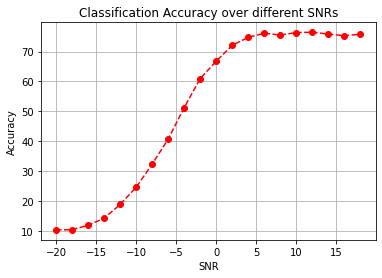

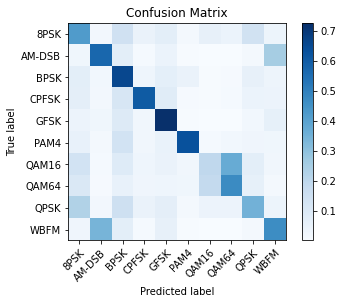

In [ ]:
print("Fully connected classifier")
checkpoint_dir = os.path.dirname("/content/drive/MyDrive/AI_assignment4/models/rawModels/fc_model/model.h5")
#fc_model = train_fc_model(X_train, y_train, checkpoint_dir)
fc_model = keras.models.load_model(checkpoint_dir)
y_pred_ann = fc_model.predict(X_test)
plot_results(y_pred_ann, y_test, snr_test)
plot_confusion_matrix(y_test, y_pred_ann, mods)
print_results(y_pred_ann, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.66,10.69,11.98,13.4,18.18,25.29,35.52,47.31,60.0,70.76,77.86,80.52,81.56,82.16,82.38,82.42,82.67,82.44,81.83,82.21


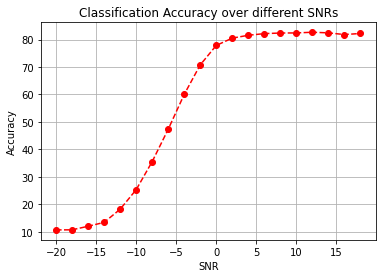

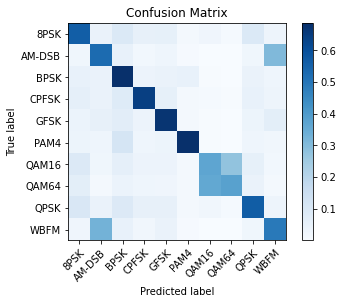

In [ ]:
checkpoint_path = "/content/drive/MyDrive/AI_assignment4/models/rawModels/cnn_model/model.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cnn_model = keras.models.load_model(checkpoint_dir)
y_pred_cnn = fcmodels.predict(X_test)
plot_results(y_pred_cnn, y_test, snr_test)
plot_confusion_matrix(y_test, y_pred_cnn, mods)
print_results(y_pred_cnn, y_test, snr_test)

In [ ]:
del(fc_model)
del(y_pred_ann)
del(cnn_model)
del(y_pred_cnn)
del(X_train)
del(X_test)
del(y_test)
del(y_train)
del(raw_data)
gc.collect()

## test derivative data

In [ ]:
der_data = extract_features('derivative')
X_train, X_test, y_train, y_test, snr_train, snr_test = split_data(der_data)  

In [ ]:
work_on_data(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


logistic regression classifier acc = 0.90004
Decision Tree classifier acc = 0.8995466666666667
Random Forest classifier acc = 0.90004


In [ ]:
#logistic regression classifier
acc = classifier("logistic_regression_classifier",X_train, X_test, y_train, y_test)
print("logistic regression classifier acc =", acc)

#Decision Tree classifier
acc = classifier("Decision_Tree_classifier",X_train, X_test, y_train, y_test)
print("Decision Tree classifier acc =", acc)

#Random Forest classifier
acc = classifier("Random_Forest_classifier",X_train, X_test, y_train, y_test)
print("Random Forest classifier acc =", acc)

Fully connected classifier


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,9.98,10.12,10.47,11.45,14.16,18.52,24.76,31.5,38.93,45.0,49.18,54.34,57.76,62.5,65.22,68.01,68.71,68.06,66.66,64.32


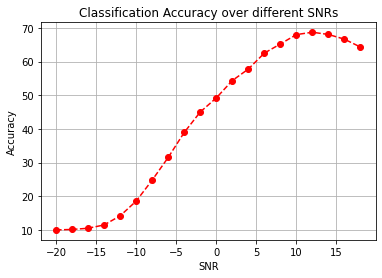

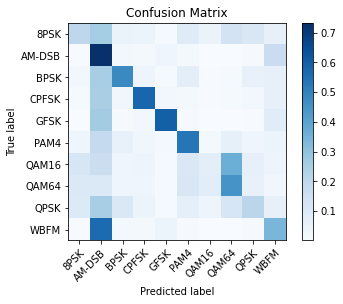

In [ ]:
print("Fully connected classifier")
checkpoint_dir = os.path.dirname("/content/drive/MyDrive/AI_assignment4/models/derivativeModels/fc_model/model.h5")
#fc_model = train_fc_model(X_train, y_train, checkpoint_dir)
fc_model = keras.models.load_model(checkpoint_dir)
y_pred_ann = fc_model.predict(X_test)
plot_results(y_pred_ann, y_test, snr_test)
plot_confusion_matrix(y_test, y_pred_ann, mods)
print_results(y_pred_ann, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,9.92,10.21,10.71,10.28,12.27,15.14,19.43,26.05,34.84,44.51,51.64,58.78,65.07,70.1,70.81,71.04,70.23,69.99,68.64,68.44


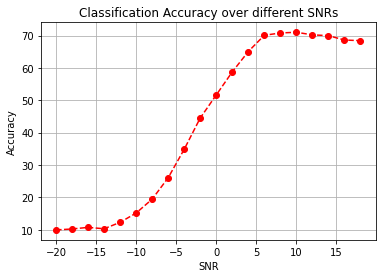

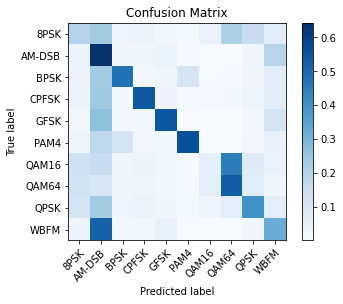

In [ ]:
checkpoint_path = "/content/drive/MyDrive/AI_assignment4/models/derivativeModels/cnn_model/model.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cnn_model = keras.models.load_model(checkpoint_dir)
y_pred_cnn = cnn_model.predict(X_test)
plot_results(y_pred_cnn, y_test, snr_test)
plot_confusion_matrix(y_test, y_pred_cnn, mods)
print_results(y_pred_cnn, y_test, snr_test)

In [ ]:
#del(fc_model)
#del(y_pred_ann)
#del(cnn_model)
#del(y_pred_cnn)
del(X_train)
del(X_test)
del(y_test)
del(y_train)
del(der_data)
gc.collect()

0

## test integral data

In [ ]:
int_data = extract_features('integral')
X_train, X_test, y_train, y_test, snr_train, snr_test = split_data(int_data)  

In [ ]:
work_on_data(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


logistic regression classifier acc = 0.90004
Decision Tree classifier acc = 0.8987933333333333
Random Forest classifier acc = 0.90004


Fully connected classifier


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.72,10.64,12.07,14.05,18.58,24.2,31.13,37.36,46.14,52.84,57.91,61.33,62.96,64.1,63.16,63.23,63.19,63.14,62.84,62.78


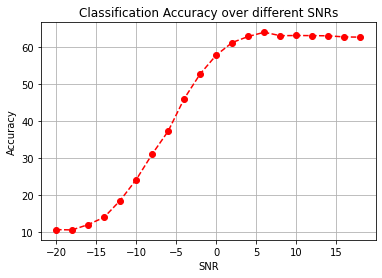

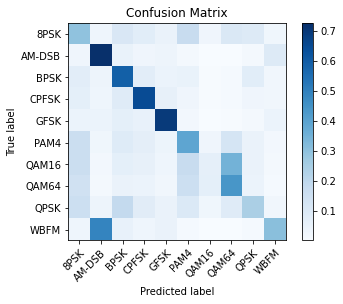

In [ ]:
print("Fully connected classifier")
checkpoint_dir = os.path.dirname("/content/drive/MyDrive/AI_assignment4/models/integralModels/fc_model/model.h5")
#fc_model = train_fc_model(X_train, y_train, checkpoint_dir)
fc_model = keras.models.load_model(checkpoint_dir)
y_pred_ann = fc_model.predict(X_test)
plot_results(y_pred_ann, y_test, snr_test)
plot_confusion_matrix(y_test, y_pred_ann, mods)
print_results(y_pred_ann, y_test, snr_test)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.47,10.54,11.15,13.12,16.54,24.62,32.82,41.11,51.4,60.6,67.01,71.55,73.62,75.38,74.85,74.74,74.96,74.85,74.6,74.78


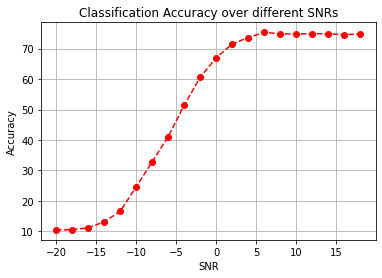

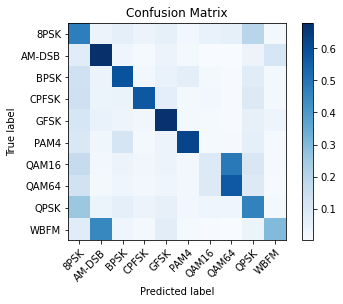

In [ ]:
checkpoint_path = "/content/drive/MyDrive/AI_assignment4/models/integralModels/cnn_model/model.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cnn_model = keras.models.load_model(checkpoint_dir)
y_pred_cnn = cnn_model.predict(X_test)
plot_results(y_pred_cnn, y_test, snr_test)
plot_confusion_matrix(y_test, y_pred_cnn, mods)
print_results(y_pred_cnn, y_test, snr_test)

In [ ]:
del(fc_model)
del(cnn_model)
del(y_pred_ann)
del(cnn_model)
del(y_pred_cnn)
del(X_train)
del(X_test)
del(y_test)
del(y_train)
del(int_data)
gc.collect()

## test combination data

In [ ]:
comb_data = extract_features('raw', 'integral')
X_train, X_test, y_train, y_test, snr_train, snr_test = split_data(comb_data)  

In [ ]:
checkpoint_dir = os.path.dirname( "/content/drive/MyDrive/AI_assignment4/models/combinationModels/cnn_model/model.h5")
cnn_model = train_cnn_model(X_train, y_train, checkpoint_dir)
y_pred_cnn = cnn_model.predict(X_test)
plot_results(y_pred_cnn, y_test, snr_test)
plot_confusion_matrix(y_test, y_pred_cnn, mods)
print_results(y_pred_cnn, y_test, snr_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 4, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 126, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 124, 16)        6160      
_________________________________________________________________
flatten (Flatten)            (None, 5952)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               761984    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 769,690
Trainable params: 769,690
Non-trainable params: 0
__________________________________________________

In [ ]:
work_on_data(comb_data)

In [ ]:
print("Fully connected classifier")
checkpoint_dir = os.path.dirname("/content/drive/MyDrive/AI_assignment4/models/combinationModels/fc_model/model.h5")
#fc_model = train_fc_model(X_train, y_train, checkpoint_dir)
fc_model = keras.models.load_model(checkpoint_dir)
y_pred_ann = fc_model.predict(X_test)
plot_results(y_pred_ann, y_test, snr_test)
plot_confusion_matrix(y_test, y_pred_ann, mods)
print_results(y_pred_ann, y_test, snr_test)

In [ ]:
checkpoint_dir = os.path.dirname( "/content/drive/MyDrive/AI_assignment4/models/combinationModels/cnn_model/model.h5")
cnn_model = keras.models.load_model(checkpoint_dir)
y_pred_cnn = cnn_model.predict(X_test)
plot_results(y_pred_cnn, y_test, snr_test)
plot_confusion_matrix(y_test, y_pred_cnn, mods)
print_results(y_pred_cnn, y_test, snr_test)

In [ ]:
del(fc_model)
del(y_pred_ann)
del(cnn_model)
del(y_pred_cnn)
del(X_train)
del(X_test)
del(y_test)
del(y_train)
del(comb_data)
gc.collect()